### Master of Applied Artificial Intelligence

**Course: TC4033 - Autonomous Driving**

<img src="./../assets/logo.png" alt="TEC DE MONTERREY" width="500"/>

**PEDESTRIAN DETECTION WITH HOG AND SVM**

Tutor: Dr. David Antonio Torres


Team members:
* Rafael Bernando Orozco Palma - A01795359
* Arantxa Stephania Coronel González - A01620352
* Alejandro Calderon Aguilar - A01795353

# Import libraries

In [75]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
import glob
import os
import pandas as pd

from tqdm import tqdm

from utils.pedestrians import Pedestrians
from utils.utils import Utils


# Se importan los dos datasets 
### https://docs.python.org/3/library/glob.html

In [48]:
pedestrian_imgs_path = "data/train/JPEGImages/*.jpg"
pedestrian_xmls_path = "data/train/Annotations/*.xml"

nrows = 5
ncols = 2
figsize=(12, 18)

In [49]:
pedestrian = Pedestrians(image_file_path=pedestrian_imgs_path, xml_file_path=pedestrian_xmls_path)

Pedestrians dataset generated


In [76]:
utils = Utils()

In [51]:
pedestrians_df = pd.read_csv(pedestrian.dataset_name)
pedestrians_df.head()

,filename,label
0,data/pedestrian_crops/image (1)_0.jpg,1
1,data/pedestrian_crops/image (10)_0.jpg,1
2,data/pedestrian_crops/image (100)_0.jpg,1
3,data/pedestrian_crops/image (100)_1.jpg,1
4,data/pedestrian_crops/image (101)_0.jpg,1


In [52]:
pedestrians_df.count()

filename    2066
label       2066
dtype: int64

In [53]:
pedestrians_df["label"].value_counts()

label
1    1106
0     960
Name: count, dtype: int64

# Se muestra una imagen con vehículo

In [54]:
random_pedestrians = pedestrians_df.sample(n=10)
random_pedestrians.head()

,filename,label
452,data/pedestrian_crops/image (289)_2.jpg,1
1771,data/pedestrian_crops/image (840)_0.jpg,0
332,data/pedestrian_crops/image (232)_1.jpg,1
1952,data/pedestrian_crops/image (910)_0.jpg,0
1363,data/pedestrian_crops/image (653)_1.jpg,0


In [55]:
tmp_pedestrian_path_imgs= random_pedestrians.get("filename").to_list()
tmp_pedestrian_labels = random_pedestrians.get("label").apply(lambda x: "Pedestrian" if x == 1 else "Not pedestrian").to_list()

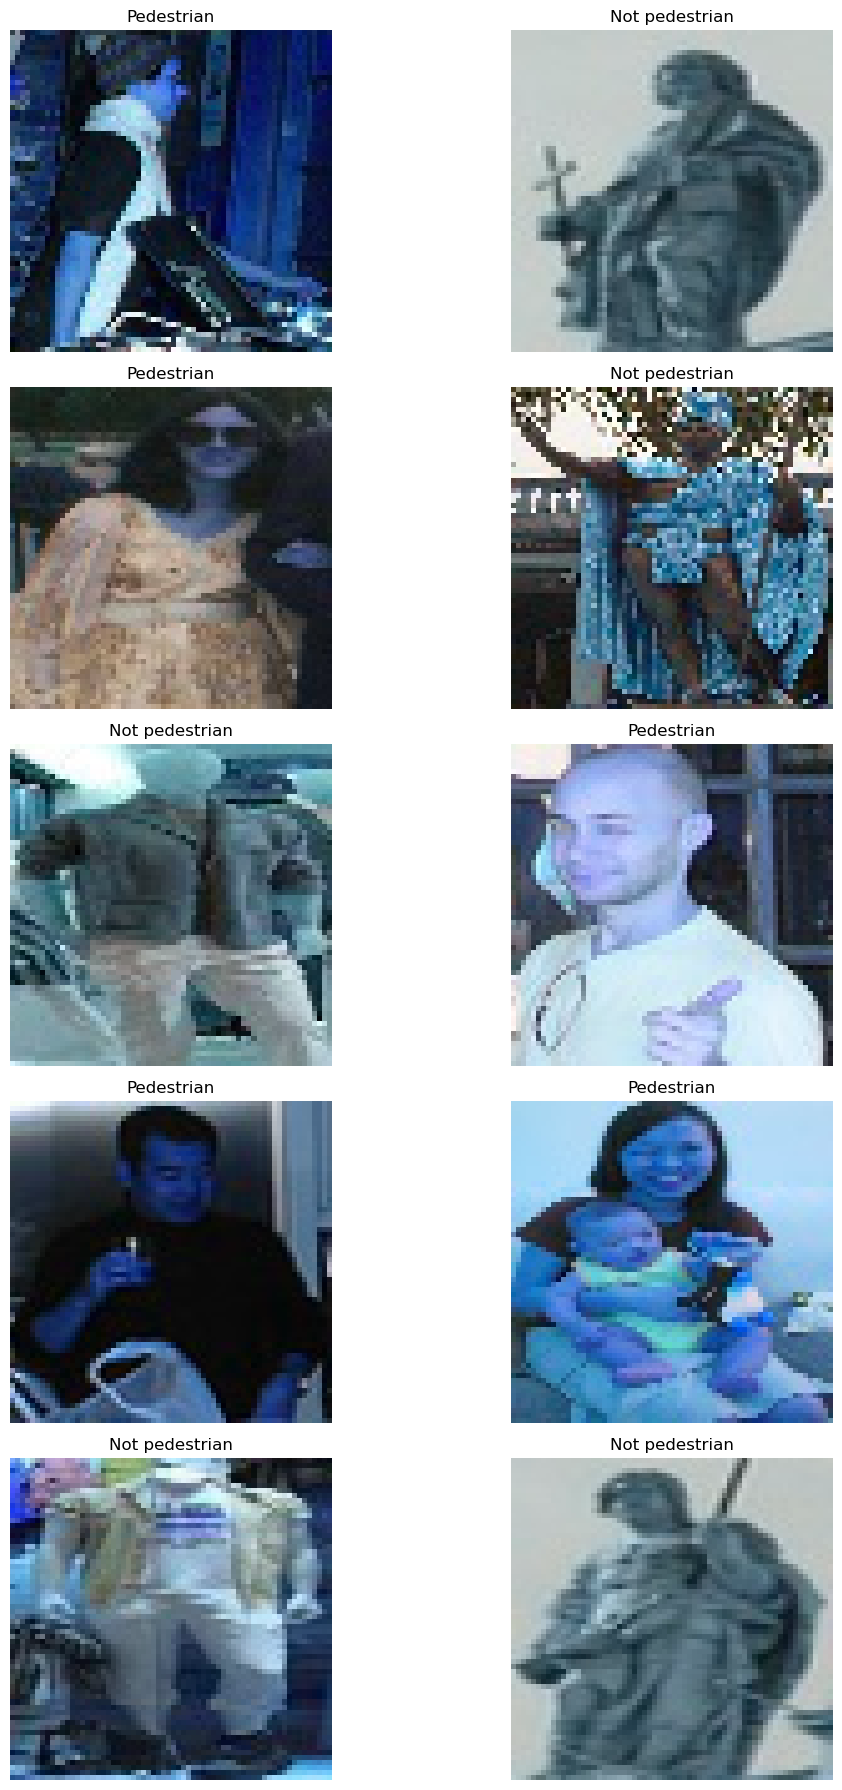

In [56]:
tmp_pedestrian_imgs = utils.read_images(path_images=tmp_pedestrian_path_imgs)
utils.plot_images(images=tmp_pedestrian_imgs, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

# Para fines de demostración se calcula el HOG de la imagen

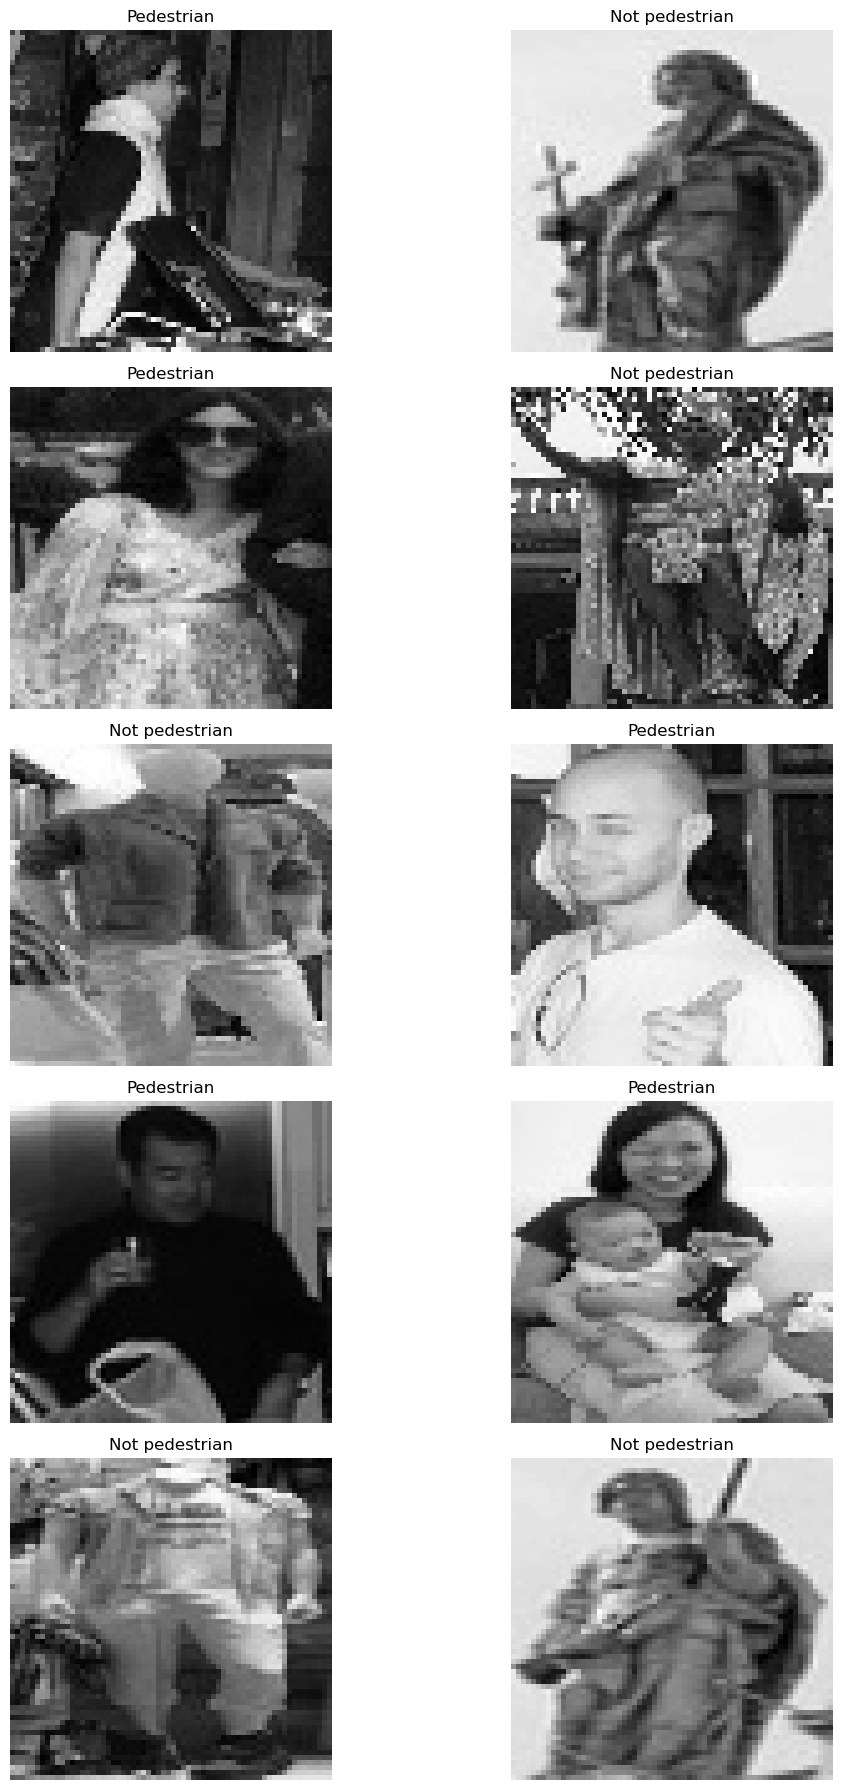

In [57]:
imgs_gray = utils.convert_BGR2GRAY(color_images=tmp_pedestrian_imgs)
utils.plot_images(images=imgs_gray, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

In [58]:
hog_features = []

for gray_img in imgs_gray:
    features,hog_img = utils.extract_hog(gray_img)
    hog_features.append({
        "features": features,
        "hog_img": hog_img
    })


In [59]:
hog_imgs = []
for idx, hog_feature in enumerate(hog_features, 0):
    hog_imgs.append(hog_feature["hog_img"])
    print(f"IMAGE_{idx}.- FEATURE SHAPE -> {hog_feature['features'].shape} [*] IMG SHAPE -> {hog_feature['hog_img'].shape}")

IMAGE_0.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_1.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_2.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_3.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_4.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_5.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_6.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_7.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_8.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_9.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)


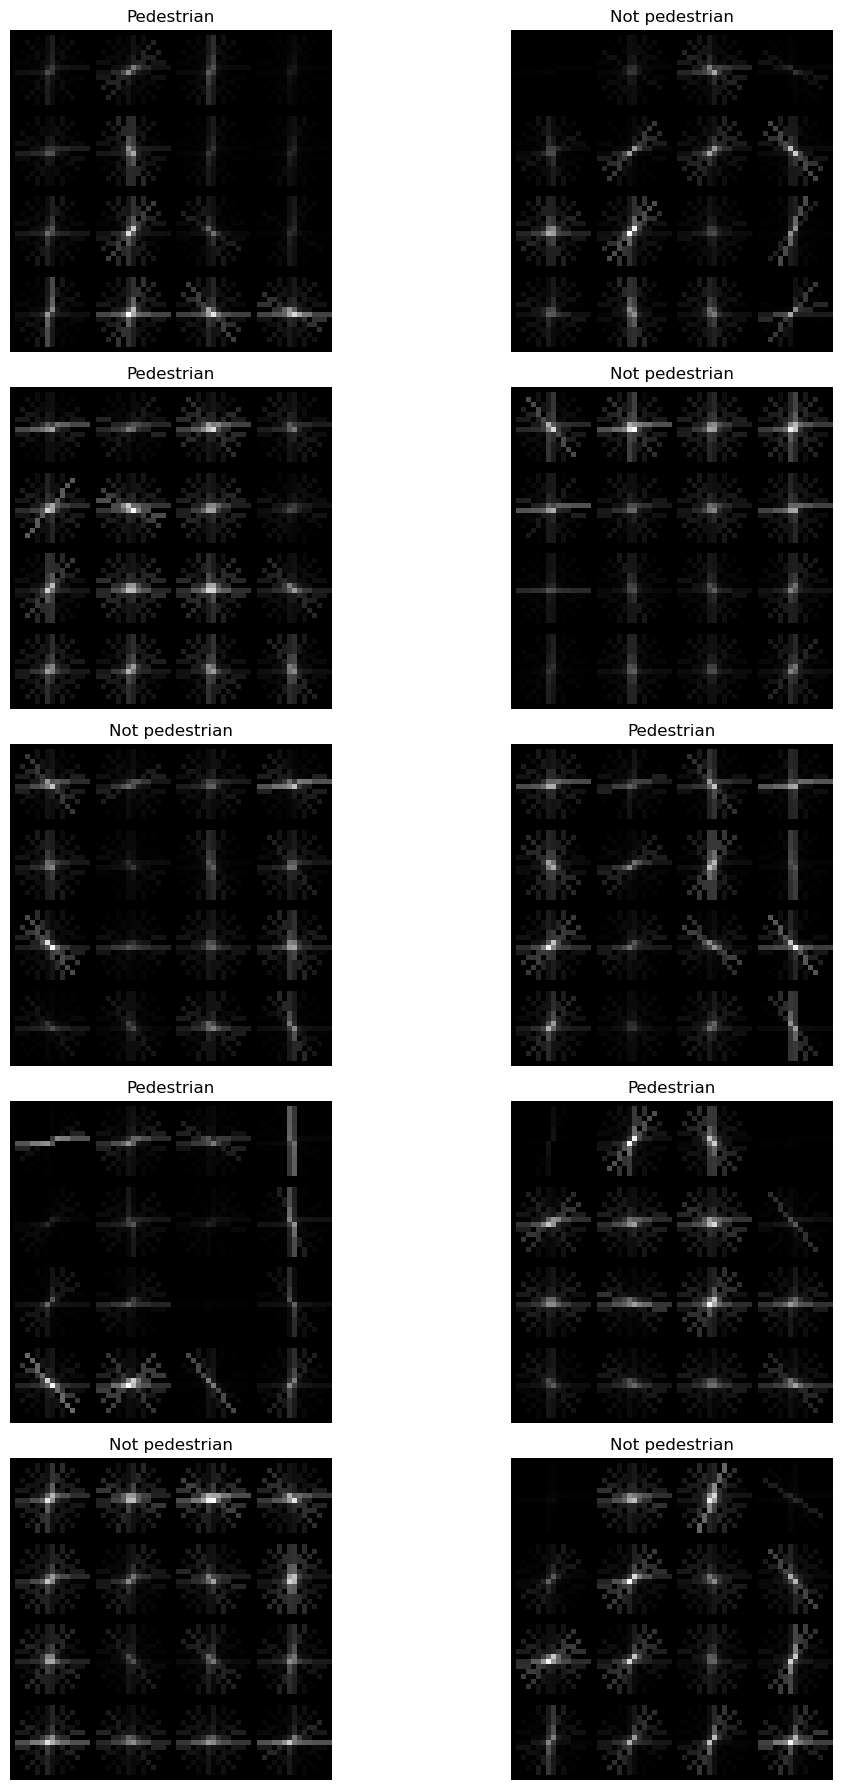

In [60]:
utils.plot_images(images=hog_imgs, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

# Se extraen las features del HOG para ambos tipos de datos

In [61]:
utils.process_hog_imgs(pedestrians_df)

100%|██████████| 2066/2066 [00:08<00:00, 236.60it/s]


In [31]:
df = pd.read_pickle("data/hog_pedestrians_dataset.pkl")
df.head()

,filename,label,features
0,data/pedestrian_crops/image (1)_0.jpg,1,"[0.17621226757272837, 0.11970332756318078, 0.2..."
1,data/pedestrian_crops/image (10)_0.jpg,1,"[0.17434682525850692, 0.16302948567861925, 0.1..."
2,data/pedestrian_crops/image (100)_0.jpg,1,"[0.14285142494707212, 0.038435981037694036, 0...."
3,data/pedestrian_crops/image (100)_1.jpg,1,"[0.09548145701380828, 0.025004826031810708, 0...."
4,data/pedestrian_crops/image (101)_0.jpg,1,"[0.2433784390606614, 0.010232653819074329, 0.0..."


In [62]:
X = df["features"].tolist()
y = np.array(df["label"].tolist())
X = np.vstack(X).astype(np.float64)
image_ids = df["filename"].tolist()

In [63]:
print(X.shape)
print(y.shape)
print(len(image_ids))

(2066, 396)
(2066,)
2066


# Se generan los datos de entrenamiento y de prueba

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, image_ids, test_size = 0.3, random_state = 42)

In [65]:
X_train.shape

(1446, 396)

In [66]:
X_test.shape

(620, 396)

In [67]:
id_train[:5]

['data/pedestrian_crops/image (736)_4.jpg',
 'data/pedestrian_crops/image (485)_1.jpg',
 'data/pedestrian_crops/image (519)_1.jpg',
 'data/pedestrian_crops/image (225)_1.jpg',
 'data/pedestrian_crops/image (50)_0.jpg']

In [68]:
id_test[:5]

['data/pedestrian_crops/image (710)_0.jpg',
 'data/pedestrian_crops/image (915)_2.jpg',
 'data/pedestrian_crops/image (647)_0.jpg',
 'data/pedestrian_crops/image (846)_1.jpg',
 'data/pedestrian_crops/image (113)_0.jpg']

# Se importa el Clasificador y se entrena

In [69]:
#from sklearn.svm import LinearSVC

#svc_model = LinearSVC()
#svc_model.fit(X_train, y_train)
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

In [70]:
y_predict = svc_model.predict(X_test)

<Axes: >

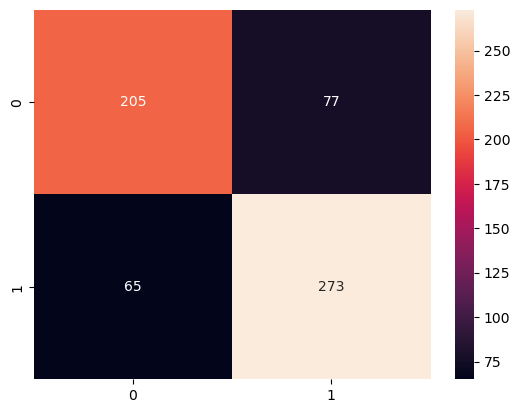

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")

In [72]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       282
           1       0.78      0.81      0.79       338

    accuracy                           0.77       620
   macro avg       0.77      0.77      0.77       620
weighted avg       0.77      0.77      0.77       620



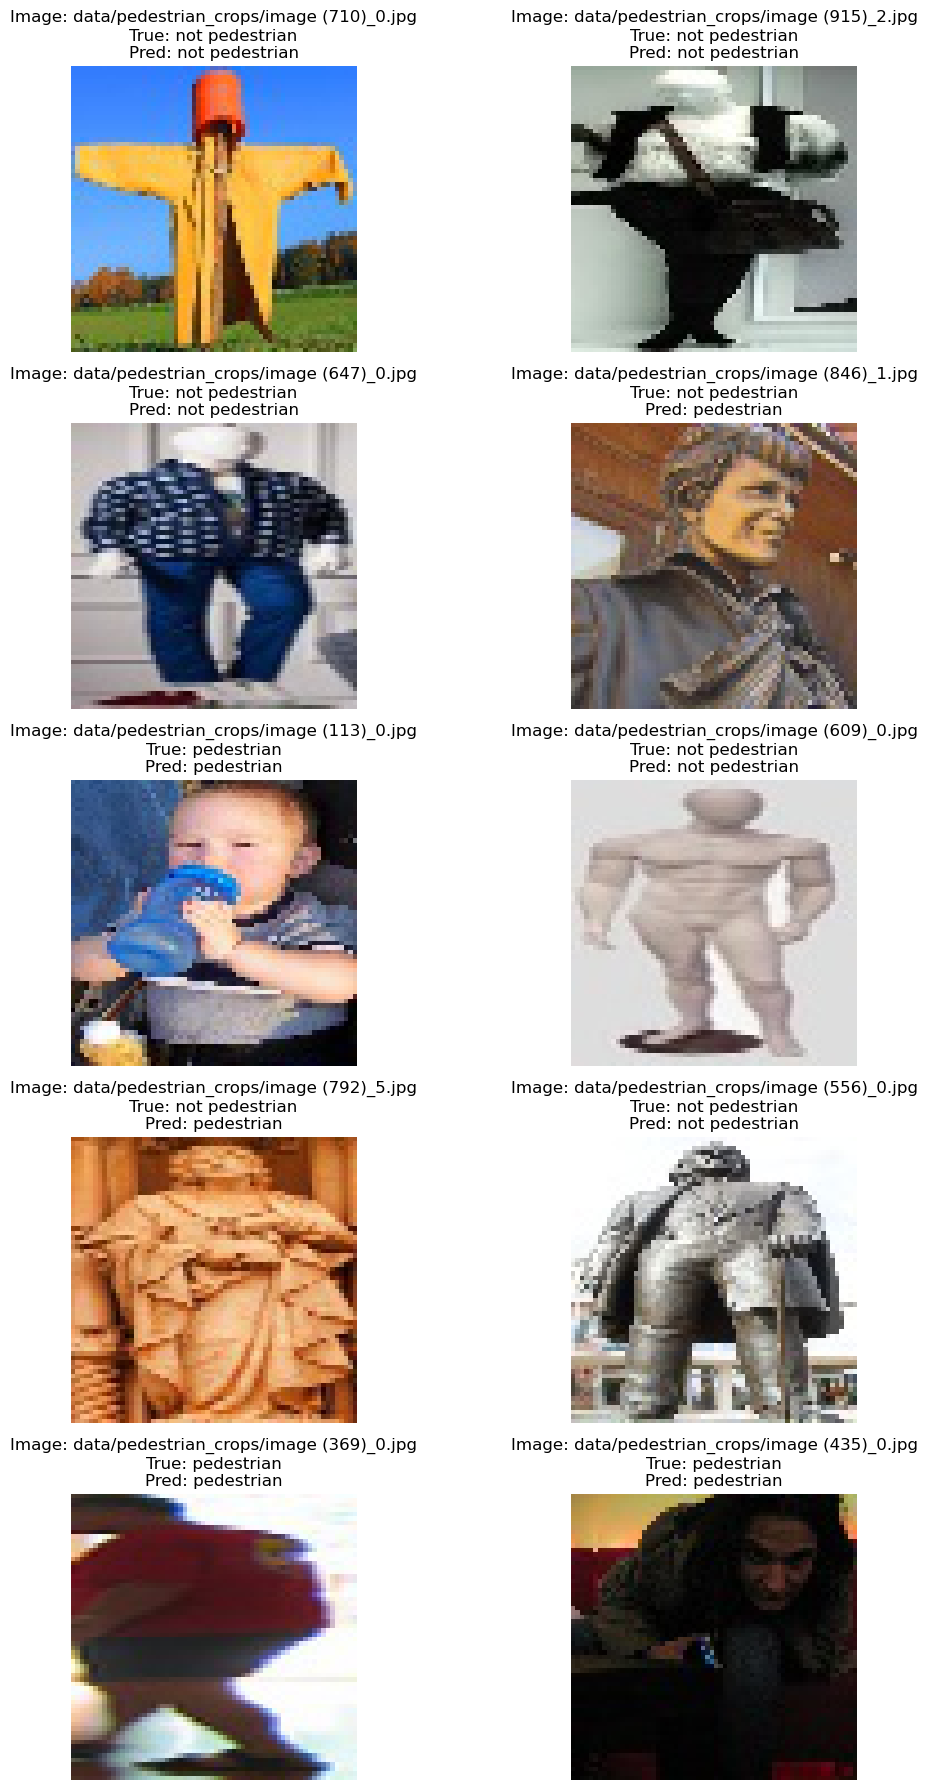

In [80]:
utils.show_predictions(image_ids=id_test, y_true= y_test, y_pred=y_predict, nrows=nrows, ncols=ncols, figsize=figsize)

# GridSearchCV

In [81]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [82]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.528 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.529 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.529 total time=   0.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.648 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.654 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.647 total time=   0.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.661 total time=   0.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.664 total time=   0.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.531 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [83]:
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [84]:
grid.best_estimator_

SVC(C=10, gamma=1)

In [85]:
grid_predictions = grid.predict(X_test)

<Axes: >

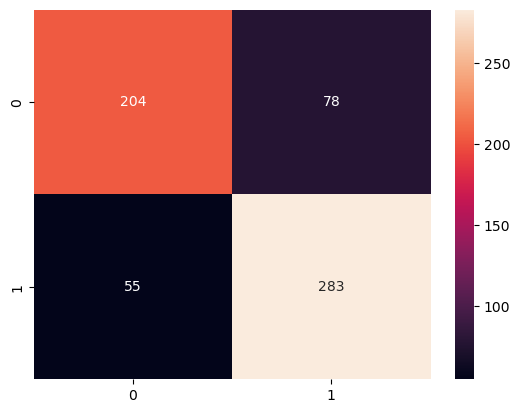

In [86]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

In [88]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       282
           1       0.78      0.84      0.81       338

    accuracy                           0.79       620
   macro avg       0.79      0.78      0.78       620
weighted avg       0.79      0.79      0.78       620



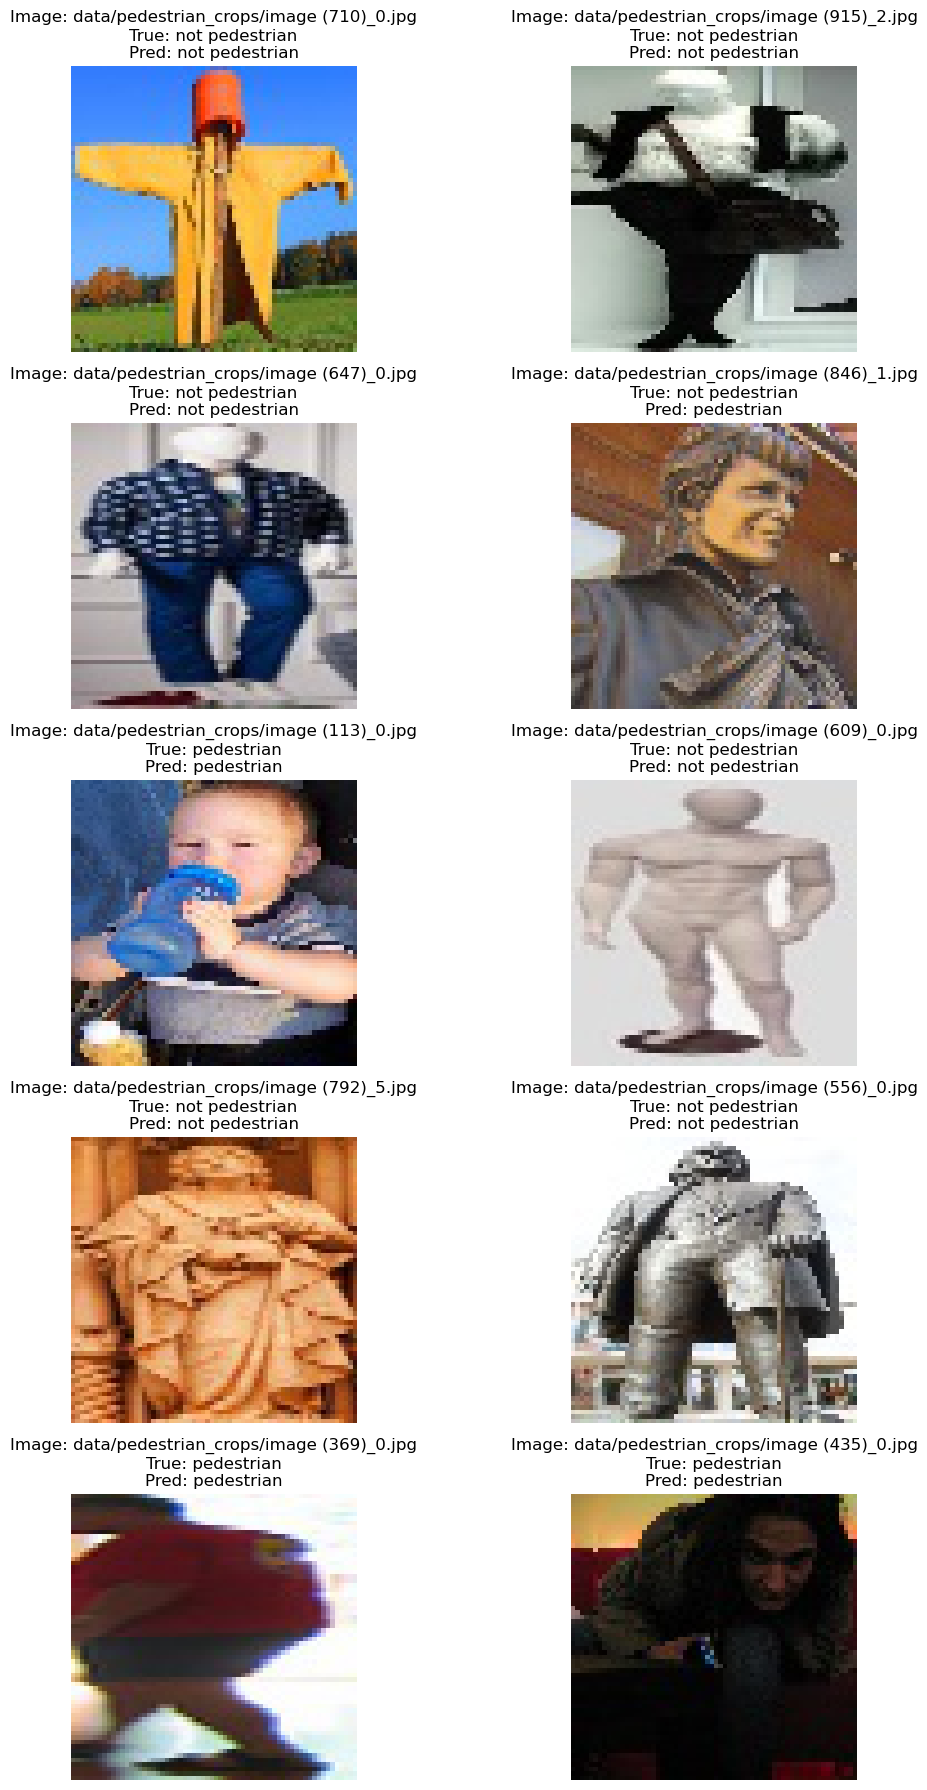

In [89]:
utils.show_predictions(image_ids=id_test, y_true= y_test, y_pred=grid_predictions, nrows=nrows, ncols=ncols, figsize=figsize)